1. 自定义实现

In [212]:
class DSSMModel(tf.keras.Model):
    def __init__(self, user_feature_dims, item_feature_dims, embedding_dim=8):
        super(DSSMModel, self).__init__()

        # 为每个用户特征定义嵌入层
        self.user_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"user_emb_{feat}")
            for feat, vocab_size in user_feature_dims.items()
        }
        # 为每个商品特征定义嵌入层
        self.item_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"item_emb_{feat}")
            for feat, vocab_size in item_feature_dims.items()
        }

        # 用户侧的全连接层
        self.user_dense1 = Dense(128, activation='relu')
        self.user_dense2 = Dense(64, activation='relu')

        # 商品侧的全连接层
        self.item_dense1 = Dense(128, activation='relu')
        self.item_dense2 = Dense(64, activation='relu')

        # 输出层，使用sigmoid激活进行二分类预测
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        # 分离用户输入和商品输入
        user_inputs = inputs[:len(self.user_embeddings)]
        item_inputs = inputs[len(self.user_embeddings):]

        # 用户特征的嵌入查找
        user_embeds = [Flatten()(self.user_embeddings[feat](inp)) for feat, inp in zip(self.user_embeddings, user_inputs)]
        user_vector = Concatenate()(user_embeds)
        user_vector = self.user_dense1(user_vector)
        user_vector = self.user_dense2(user_vector)

        # 商品特征的嵌入查找
        item_embeds = [Flatten()(self.item_embeddings[feat](inp)) for feat, inp in zip(self.item_embeddings, item_inputs)]
        item_vector = Concatenate()(item_embeds)
        item_vector = self.item_dense1(item_vector)
        item_vector = self.item_dense2(item_vector)

        # 计算用户向量和商品向量的余弦相似度
        cosine_sim = tf.reduce_sum(user_vector * item_vector, axis=-1, keepdims=True) / (
            tf.norm(user_vector, axis=-1, keepdims=True) * tf.norm(item_vector, axis=-1, keepdims=True) + K.epsilon()
        )

        # 最终输出层
        output = self.output_layer(cosine_sim)
        return output

Epoch 1/10
1/1 - 2s - loss: 0.7887 - accuracy: 0.3511 - auc: 0.4556 - val_loss: 0.7601 - val_accuracy: 0.2766 - val_auc: 0.6143
Epoch 2/10
1/1 - 0s - loss: 0.7319 - accuracy: 0.3511 - auc: 0.6408 - val_loss: 0.7306 - val_accuracy: 0.2766 - val_auc: 0.6086
Epoch 3/10
1/1 - 0s - loss: 0.6998 - accuracy: 0.3564 - auc: 0.7936 - val_loss: 0.7154 - val_accuracy: 0.2766 - val_auc: 0.6154
Epoch 4/10
1/1 - 0s - loss: 0.6849 - accuracy: 0.3617 - auc: 0.8935 - val_loss: 0.7079 - val_accuracy: 0.2766 - val_auc: 0.6324
Epoch 5/10
1/1 - 0s - loss: 0.6769 - accuracy: 0.4149 - auc: 0.9481 - val_loss: 0.7045 - val_accuracy: 0.3404 - val_auc: 0.6176
Epoch 6/10
1/1 - 0s - loss: 0.6709 - accuracy: 0.5053 - auc: 0.9747 - val_loss: 0.7040 - val_accuracy: 0.3404 - val_auc: 0.6120
Epoch 7/10
1/1 - 0s - loss: 0.6649 - accuracy: 0.5532 - auc: 0.9814 - val_loss: 0.7054 - val_accuracy: 0.3404 - val_auc: 0.6086
Epoch 8/10
1/1 - 0s - loss: 0.6582 - accuracy: 0.5798 - auc: 0.9838 - val_loss: 0.7080 - val_accuracy: 0

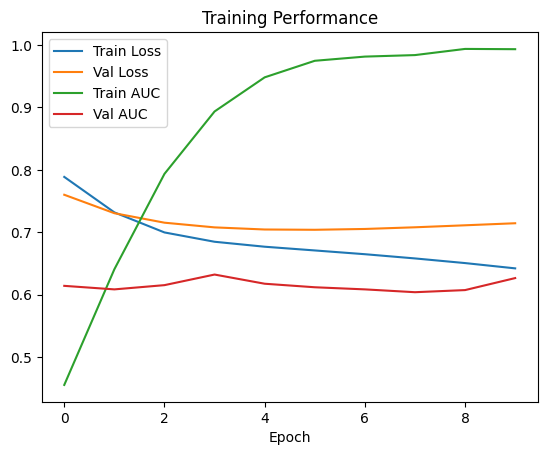

In [266]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


# 处理稠密（数值）特征的函数
def process_dense_feats(data, feats):
    # 填充缺失值为0
    data[feats] = data[feats].fillna(0)
    # 对数值特征进行标准化（均值为0，标准差为1）
    scaler = StandardScaler()
    data[feats] = scaler.fit_transform(data[feats])
    return data


# 处理稀疏（类别）特征的函数
def process_sparse_feats(data, feats):
    label_encoders = {}
    # 遍历每个类别特征
    for feat in feats:
        # 使用标签编码将字符串值转换为整数
        le = LabelEncoder()
        data[feat] = le.fit_transform(data[feat].astype(str))
        label_encoders[feat] = le
    return data, label_encoders


# 定义一个自定义的DSSM模型（Deep Structured Semantic Model）
class DSSMModel(tf.keras.Model):
    def __init__(self, user_feature_dims, item_feature_dims, embedding_dim=8):
        super(DSSMModel, self).__init__()

        # 为每个用户特征定义嵌入层
        self.user_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"user_emb_{feat}")
            for feat, vocab_size in user_feature_dims.items()
        }
        # 为每个商品特征定义嵌入层
        self.item_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"item_emb_{feat}")
            for feat, vocab_size in item_feature_dims.items()
        }

        # 用户侧的全连接层
        self.user_dense1 = Dense(128, activation='relu')
        self.user_dense2 = Dense(64, activation='relu')

        # 商品侧的全连接层
        self.item_dense1 = Dense(128, activation='relu')
        self.item_dense2 = Dense(64, activation='relu')

        # 输出层，使用sigmoid激活进行二分类预测
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        # 分离用户输入和商品输入
        user_inputs = inputs[:len(self.user_embeddings)]
        item_inputs = inputs[len(self.user_embeddings):]

        # 用户特征的嵌入查找
        user_embeds = [Flatten()(self.user_embeddings[feat](inp)) for feat, inp in zip(self.user_embeddings, user_inputs)]
        user_vector = Concatenate()(user_embeds)
        user_vector = self.user_dense1(user_vector)
        user_vector = self.user_dense2(user_vector)

        # 商品特征的嵌入查找
        item_embeds = [Flatten()(self.item_embeddings[feat](inp)) for feat, inp in zip(self.item_embeddings, item_inputs)]
        item_vector = Concatenate()(item_embeds)
        item_vector = self.item_dense1(item_vector)
        item_vector = self.item_dense2(item_vector)

        # 计算用户向量和商品向量的余弦相似度
        cosine_sim = tf.reduce_sum(user_vector * item_vector, axis=-1, keepdims=True) / (
            tf.norm(user_vector, axis=-1, keepdims=True) * tf.norm(item_vector, axis=-1, keepdims=True) + K.epsilon()
        )

        # 最终输出层
        output = self.output_layer(cosine_sim)
        return output


# 加载并处理数据的函数
def load_and_process_data():
    column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel",
                    "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
    # 读取数据集
    data = pd.read_csv(r"D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\train_2.csv",
                       sep='\t', names=column_names)

    # 定义稀疏特征和稠密特征列表
    sparse_feats_user = ["uid", "user_city", "device"]
    sparse_feats_item = ["item_id", "author_id", "item_city", "channel", "music_id"]
    dense_feats = ["time", "duration_time"]
    target = 'finish'

    # 处理特征
    data = process_dense_feats(data, dense_feats)
    data, _ = process_sparse_feats(data, sparse_feats_user)
    data, _ = process_sparse_feats(data, sparse_feats_item)

    # 将数据拆分为训练集和测试集
    train, test = train_test_split(data, test_size=0.2, random_state=42)

    # 准备训练和测试的特征输入
    user_inputs_train = [train[feat].values for feat in sparse_feats_user]
    item_inputs_train = [train[feat].values for feat in sparse_feats_item]
    user_inputs_test = [test[feat].values for feat in sparse_feats_user]
    item_inputs_test = [test[feat].values for feat in sparse_feats_item]

    # 获取类别特征的唯一值数量（用于嵌入层）
    user_dims = {feat: data[feat].nunique() for feat in sparse_feats_user}
    item_dims = {feat: data[feat].nunique() for feat in sparse_feats_item}

    return (user_inputs_train, item_inputs_train, train[target].values,
            user_inputs_test, item_inputs_test, test[target].values,
            user_dims, item_dims)


# 训练和评估模型的函数
def train_and_evaluate():
    # 加载并处理数据
    user_inputs_train, item_inputs_train, y_train, user_inputs_test, item_inputs_test, y_test, user_dims, item_dims = load_and_process_data()

    # 创建并编译DSSM模型
    model = DSSMModel(user_dims, item_dims)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    # 训练模型
    history = model.fit(user_inputs_train + item_inputs_train, y_train,
                        batch_size=256, epochs=10,
                        validation_split=0.2, verbose=2)

    # 预测并评估测试集上的表现
    preds = model.predict(user_inputs_test + item_inputs_test, batch_size=256)
    preds = model.predict(user_inputs_test + item_inputs_test, batch_size=256)
    print("Test LogLoss:", round(log_loss(y_test, preds), 4))
    print("Test AUC:", round(roc_auc_score(y_test, preds), 4))

    # 可视化
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('Training Performance')
    plt.xlabel('Epoch')
    plt.show()


# 入口点，开始训练和评估
if __name__ == "__main__":
    train_and_evaluate()


Epoch 1/10
cosine_sim-------
(None, 1)
cosine_sim-------
(None, 1)
cosine_sim-------
(None, 1)
1/1 - 2s - loss: 0.6523 - accuracy: 0.6489 - auc: 0.4765 - val_loss: 0.5997 - val_accuracy: 0.7234 - val_auc: 0.5249
Epoch 2/10
1/1 - 0s - loss: 0.6077 - accuracy: 0.6489 - auc: 0.8038 - val_loss: 0.5973 - val_accuracy: 0.7234 - val_auc: 0.5407
Epoch 3/10
1/1 - 0s - loss: 0.5742 - accuracy: 0.6489 - auc: 0.9413 - val_loss: 0.5970 - val_accuracy: 0.7234 - val_auc: 0.5158
Epoch 4/10
1/1 - 0s - loss: 0.5462 - accuracy: 0.6489 - auc: 0.9819 - val_loss: 0.5990 - val_accuracy: 0.7234 - val_auc: 0.4876
Epoch 5/10
1/1 - 0s - loss: 0.5204 - accuracy: 0.6489 - auc: 0.9939 - val_loss: 0.6013 - val_accuracy: 0.7234 - val_auc: 0.4864
Epoch 6/10
1/1 - 0s - loss: 0.4959 - accuracy: 0.6489 - auc: 0.9987 - val_loss: 0.6029 - val_accuracy: 0.7234 - val_auc: 0.4762
Epoch 7/10
1/1 - 0s - loss: 0.4734 - accuracy: 0.6543 - auc: 0.9997 - val_loss: 0.6041 - val_accuracy: 0.7234 - val_auc: 0.4729
Epoch 8/10
1/1 - 0s 

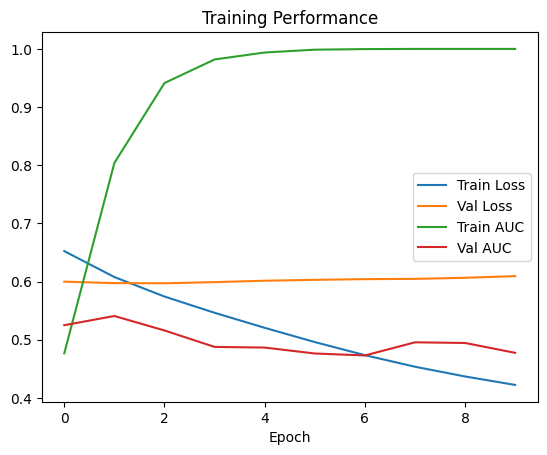

In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


def process_dense_feats(data, feats):
    data[feats] = data[feats].fillna(0)
    scaler = StandardScaler()
    data[feats] = scaler.fit_transform(data[feats])
    return data


def process_sparse_feats(data, feats):
    label_encoders = {}
    for feat in feats:
        le = LabelEncoder()
        data[feat] = le.fit_transform(data[feat].astype(str))
        label_encoders[feat] = le
    return data, label_encoders


class DSSMModel(tf.keras.Model):
    def __init__(self, user_feature_dims, item_feature_dims, embedding_dim=8):
        super(DSSMModel, self).__init__()
        self.user_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"user_emb_{feat}")
            for feat, vocab_size in user_feature_dims.items()
        }
        self.item_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"item_emb_{feat}")
            for feat, vocab_size in item_feature_dims.items()
        }

        self.user_dense1 = Dense(128, activation='relu')
        self.user_dense2 = Dense(64, activation='relu')

        self.item_dense1 = Dense(128, activation='relu')
        self.item_dense2 = Dense(64, activation='relu')

        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        user_inputs = inputs[:len(self.user_embeddings)]
        item_inputs = inputs[len(self.user_embeddings):]

        user_embeds = [Flatten()(self.user_embeddings[feat](inp)) for feat, inp in zip(self.user_embeddings, user_inputs)]
        user_vector = Concatenate()(user_embeds)
        user_vector = self.user_dense1(user_vector)
        user_vector = self.user_dense2(user_vector)

        item_embeds = [Flatten()(self.item_embeddings[feat](inp)) for feat, inp in zip(self.item_embeddings, item_inputs)]
        item_vector = Concatenate()(item_embeds)
        item_vector = self.item_dense1(item_vector)
        item_vector = self.item_dense2(item_vector)

        cosine_sim = tf.reduce_sum(user_vector * item_vector, axis=-1, keepdims=True) / (
            tf.norm(user_vector, axis=-1, keepdims=True) * tf.norm(item_vector, axis=-1, keepdims=True) + K.epsilon()
        )
        
        print('cosine_sim-------')
        print(cosine_sim.shape)
        output = self.output_layer(cosine_sim)
        return output


def load_and_process_data():
    column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel",
                    "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
    data = pd.read_csv(r"D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\train_2.csv",
                       sep='\t', names=column_names)

    sparse_feats_user = ["uid", "user_city", "device"]
    sparse_feats_item = ["item_id", "author_id", "item_city", "channel", "music_id"]
    dense_feats = ["time", "duration_time"]
    target = 'finish'

    data = process_dense_feats(data, dense_feats)
    data, _ = process_sparse_feats(data, sparse_feats_user)
    data, _ = process_sparse_feats(data, sparse_feats_item)

    train, test = train_test_split(data, test_size=0.2, random_state=42)

    user_inputs_train = [train[feat].values for feat in sparse_feats_user]
    item_inputs_train = [train[feat].values for feat in sparse_feats_item]
    user_inputs_test = [test[feat].values for feat in sparse_feats_user]
    item_inputs_test = [test[feat].values for feat in sparse_feats_item]

    user_dims = {feat: data[feat].nunique() for feat in sparse_feats_user}
    item_dims = {feat: data[feat].nunique() for feat in sparse_feats_item}

    return (user_inputs_train, item_inputs_train, train[target].values,
            user_inputs_test, item_inputs_test, test[target].values,
            user_dims, item_dims)


def train_and_evaluate():
    user_inputs_train, item_inputs_train, y_train, user_inputs_test, item_inputs_test, y_test, user_dims, item_dims = load_and_process_data()

    model = DSSMModel(user_dims, item_dims)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    history = model.fit(user_inputs_train + item_inputs_train, y_train,
                        batch_size=256, epochs=10,
                        validation_split=0.2, verbose=2)

    preds = model.predict(user_inputs_test + item_inputs_test, batch_size=256)
    print("Test LogLoss:", round(log_loss(y_test, preds), 4))
    print("Test AUC:", round(roc_auc_score(y_test, preds), 4))

    # 可视化
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('Training Performance')
    plt.xlabel('Epoch')
    plt.show()


if __name__ == "__main__":
    train_and_evaluate()


In [225]:
column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel",
                "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
data = pd.read_csv(r"D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\train_2.csv",
                   sep='\t', names=column_names)

In [226]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,57384,52,43192,142828,0,0,0,0,4513,34178,53085993699,39,喜剧,刘德华
1,3230,5,46822,231026,1,0,1,0,5330,24878,53086372896,16,"惊悚,爱情",小李子
2,1249,328,1209078,456220,2,0,0,0,39979,14274,53086458433,4,"爱情,悬疑","李连杰,成龙"
3,11928,8,1209079,456221,3,0,0,0,-1,16649,53086463774,9,"战争,剧情","李连杰,汤姆·哈迪"
4,51266,89,1209080,126416,4,0,1,0,-1,27090,53086432937,19,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,30928,30,1209236,15497,134,0,1,0,2219,34737,53084398120,21,"爱情,悬疑",巩俐
290,4112,-1,1209237,41018,125,1,0,0,-1,500,53086200656,9,战争,"汤姆·哈迪,舒淇"
291,3407,99,1209238,38830,14,0,0,0,-1,22465,53083946541,17,"惊悚,科幻","周星驰,张学友"
292,52039,292,86024,2793,60,0,1,0,-1,28869,53086431733,10,"动作,惊悚",汤姆·哈迪


In [227]:
sparse_feats_user = ["uid", "user_city", "device"]

In [228]:
sparse_feats_item = ["item_id", "author_id", "item_city", "channel", "music_id"]

In [229]:
dense_feats = ["time", "duration_time"]

In [230]:
target = 'finish'

In [231]:
data = process_dense_feats(data, dense_feats)

In [232]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,57384,52,43192,142828,0,0,0,0,4513,34178,0.250521,3.830290,喜剧,刘德华
1,3230,5,46822,231026,1,0,1,0,5330,24878,0.467755,0.593142,"惊悚,爱情",小李子
2,1249,328,1209078,456220,2,0,0,0,39979,14274,0.516757,-1.095805,"爱情,悬疑","李连杰,成龙"
3,11928,8,1209079,456221,3,0,0,0,-1,16649,0.519817,-0.392077,"战争,剧情","李连杰,汤姆·哈迪"
4,51266,89,1209080,126416,4,0,1,0,-1,27090,0.502151,1.015379,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,30928,30,1209236,15497,134,0,1,0,2219,34737,-0.663550,1.296870,"爱情,悬疑",巩俐
290,4112,-1,1209237,41018,125,1,0,0,-1,500,0.369082,-0.392077,战争,"汤姆·哈迪,舒淇"
291,3407,99,1209238,38830,14,0,0,0,-1,22465,-0.922249,0.733888,"惊悚,科幻","周星驰,张学友"
292,52039,292,86024,2793,60,0,1,0,-1,28869,0.501461,-0.251331,"动作,惊悚",汤姆·哈迪


In [233]:
data, _ = process_sparse_feats(data, sparse_feats_user)

In [234]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,220,104,43192,142828,0,0,0,0,4513,146,0.250521,3.830290,喜剧,刘德华
1,106,102,46822,231026,1,0,1,0,5330,91,0.467755,0.593142,"惊悚,爱情",小李子
2,15,91,1209078,456220,2,0,0,0,39979,29,0.516757,-1.095805,"爱情,悬疑","李连杰,成龙"
3,12,121,1209079,456221,3,0,0,0,-1,45,0.519817,-0.392077,"战争,剧情","李连杰,汤姆·哈迪"
4,200,125,1209080,126416,4,0,1,0,-1,96,0.502151,1.015379,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,93,86,1209236,15497,134,0,1,0,2219,150,-0.663550,1.296870,"爱情,悬疑",巩俐
290,154,0,1209237,41018,125,1,0,0,-1,249,0.369082,-0.392077,战争,"汤姆·哈迪,舒淇"
291,123,128,1209238,38830,14,0,0,0,-1,83,-0.922249,0.733888,"惊悚,科幻","周星驰,张学友"
292,204,83,86024,2793,60,0,1,0,-1,106,0.501461,-0.251331,"动作,惊悚",汤姆·哈迪


In [235]:
data, _ = process_sparse_feats(data, sparse_feats_item)

In [236]:
data

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
0,220,104,240,36,1,0,0,0,71,146,0.250521,3.830290,喜剧,刘德华
1,106,102,243,101,2,0,1,0,79,91,0.467755,0.593142,"惊悚,爱情",小李子
2,15,91,9,175,48,0,0,0,64,29,0.516757,-1.095805,"爱情,悬疑","李连杰,成龙"
3,12,121,10,176,59,0,0,0,0,45,0.519817,-0.392077,"战争,剧情","李连杰,汤姆·哈迪"
4,200,125,11,21,70,0,1,0,0,96,0.502151,1.015379,剧情,"巩俐,舒淇"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,93,86,167,42,41,0,1,0,30,150,-0.663550,1.296870,"爱情,悬疑",巩俐
290,154,0,168,162,31,1,0,0,0,249,0.369082,-0.392077,战争,"汤姆·哈迪,舒淇"
291,123,128,169,151,43,0,0,0,0,83,-0.922249,0.733888,"惊悚,科幻","周星驰,张学友"
292,204,83,277,120,93,0,1,0,0,106,0.501461,-0.251331,"动作,惊悚",汤姆·哈迪


In [237]:
 train, test = train_test_split(data, test_size=0.2, random_state=42)

In [238]:
train

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
181,183,19,104,187,51,3,0,0,67,27,-0.865223,-1.377296,"惊悚,爱情","周星驰,舒淇"
209,7,0,120,83,12,1,0,0,0,160,-1.237583,-0.392077,"悬疑,剧情",成龙
168,113,0,96,12,132,1,0,0,0,254,-1.916909,-0.955059,悬疑,张学友
6,19,76,208,251,92,0,1,0,0,99,0.499315,-1.095805,"战争,剧情","马特·达蒙,艾米丽·布朗特"
224,35,32,131,82,17,0,0,0,0,58,0.455255,-0.251331,"战争,动作","张学友,汤姆·哈迪"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,210,0,108,38,6,1,0,0,46,220,-0.043275,-0.392077,"惊悚,喜剧",刘德华
71,107,57,49,85,103,0,0,0,0,19,0.170527,-0.532823,动作,周星驰
106,280,67,284,8,102,0,0,0,0,82,0.467384,-1.095805,"悬疑,战争",刘德华
270,207,28,157,200,34,0,0,0,27,135,-0.829279,-0.392077,喜剧,刘德华


In [239]:
test

,uid,user_city,item_id,author_id,item_city,channel,finish,like,music_id,device,time,duration_time,actors,genres
33,42,111,26,178,60,0,0,0,0,100,0.444967,-0.251331,"科幻,悬疑",刘德华
9,221,0,15,77,125,1,0,0,59,185,0.098963,0.311651,"悬疑,惊悚","刘德华,张学友"
146,86,51,86,248,103,0,1,0,0,15,0.458333,-0.673568,动作,汤姆·哈迪
282,143,105,192,72,102,0,0,0,91,239,0.454497,-0.251331,惊悚,"马特·达蒙,李连杰"
261,262,15,152,68,28,0,0,0,34,139,0.456955,0.593142,"悬疑,动作",舒淇
125,131,16,173,233,70,0,1,0,0,17,0.507581,-0.673568,"剧情,战争","马特·达蒙,张学友"
108,49,109,67,108,72,0,0,0,25,72,0.426535,-0.251331,动作,巩俐
206,288,25,119,56,117,0,1,0,66,63,0.182873,-0.110586,"剧情,喜剧",马特·达蒙
109,73,117,174,265,69,0,1,0,0,76,0.501414,-0.392077,"动作,爱情","小李子,刘德华"
42,16,26,31,211,67,0,1,0,88,132,0.497196,2.563580,喜剧,李连杰


In [240]:
train.shape

(235, 14)

In [241]:
test.shape

(59, 14)

In [242]:
user_inputs_train = [train[feat].values for feat in sparse_feats_user]

In [243]:
user_inputs_train

[array([183,   7, 113,  19,  35, 268,  17,  23,  84, 260, 115, 142, 205,
        148,  37, 215, 266,   5, 231,  10, 136, 274, 158, 230, 279, 247,
        198, 240, 251, 109,  90, 202,  56,   6, 140, 119, 244, 271, 214,
         59, 259,  28, 190, 120,  66, 139, 218,  25, 287, 224, 184, 137,
        146, 210, 163, 159, 155, 227, 261, 164, 157, 196, 229, 216, 243,
         76,  99,  85, 226, 281,  15, 151, 277, 215, 121, 176, 166,  39,
        172, 283, 263, 192, 179, 125, 195, 150, 278,   9, 178, 169, 149,
          4,  46,  68, 267, 114, 133, 185,  30,  87, 181, 285, 211,  50,
        156, 193,  36, 194, 135, 124,  93, 220,  82, 174, 167,  88,  83,
         22, 256,  75,  60, 100, 134, 118,  45, 154, 127,  96, 144, 200,
        257,  80, 199,  21, 201, 258, 132, 225,  34,  43, 110,  48, 250,
        171, 177,  61, 170, 117, 282,  77, 145, 235, 122, 162,  81, 264,
         52, 275, 102,  53,   2, 265,  24, 212,  29, 173, 246, 104, 103,
         69, 165, 242, 234, 262, 141,  63,  12,   0

In [244]:
item_inputs_train = [train[feat].values for feat in sparse_feats_item]

In [245]:
item_inputs_train

[array([104, 120,  96, 208, 131,  88, 255,  46,  59, 221,  51, 242, 143,
        213, 164,  50, 283, 257, 196, 278,  73,   0,  17,  63, 262, 155,
         47, 256,   8,  70,  74, 203,  61,  18,  97,  56, 135, 268, 101,
         21, 100, 246, 248, 240, 253, 270,  28, 105, 124, 261,   3,  91,
        190, 129,  90,  25, 158, 179, 122,  82, 136, 156,  60, 102, 289,
        116, 274, 106,  48, 171,   9,  71,  85, 151,  76, 146, 148, 220,
         52, 250, 204, 288,  66,  84, 218, 138,   5, 118,  45, 107,   7,
        276, 249, 183, 224,  83, 247, 180,  92, 286, 209, 112, 237,  30,
        205, 206, 239,  23, 258, 254, 167, 240, 153, 186, 233, 214, 145,
         62,  27,  42, 194, 130, 175, 134,  16, 168, 177,  24, 126,  11,
        271, 170, 181,  95, 113, 141,  81, 236,  80, 232, 165,  14, 219,
        188,  44,  33, 235,  89, 282,  77, 193,  87, 200, 149, 272,  54,
        229, 123,  29, 133, 265, 142, 115, 244,  35, 281, 238,   4, 285,
         94,  32, 264, 266, 259, 128, 137,  10,  65

In [246]:
def load_and_process_data():
    column_names = ["uid", "user_city", "item_id", "author_id", "item_city", "channel",
                    "finish", "like", "music_id", "device", "time", "duration_time", "actors", "genres"]
    data = pd.read_csv(r"D:\\software\\pycharm_repository\\StarMaker\\MultiRecSys\\data_files\\train_2.csv",
                       sep='\t', names=column_names)

    sparse_feats_user = ["uid", "user_city", "device"]
    sparse_feats_item = ["item_id", "author_id", "item_city", "channel", "music_id"]
    dense_feats = ["time", "duration_time"]
    target = 'finish'

    data = process_dense_feats(data, dense_feats)
    data, _ = process_sparse_feats(data, sparse_feats_user)
    data, _ = process_sparse_feats(data, sparse_feats_item)

    train, test = train_test_split(data, test_size=0.2, random_state=42)

    user_inputs_train = [train[feat].values for feat in sparse_feats_user]
    item_inputs_train = [train[feat].values for feat in sparse_feats_item]
    user_inputs_test = [test[feat].values for feat in sparse_feats_user]
    item_inputs_test = [test[feat].values for feat in sparse_feats_item]

    user_dims = {feat: data[feat].nunique() for feat in sparse_feats_user}
    item_dims = {feat: data[feat].nunique() for feat in sparse_feats_item}

    return (user_inputs_train, item_inputs_train, train[target].values,
            user_inputs_test, item_inputs_test, test[target].values,
            user_dims, item_dims)

In [247]:
user_inputs_train, item_inputs_train, y_train, user_inputs_test, item_inputs_test, y_test, user_dims, item_dims = load_and_process_data()

In [254]:
y_train.shape

(235,)

In [255]:
user_dims

{'uid': 289, 'user_city': 129, 'device': 289}

In [256]:
item_dims

{'item_id': 291,
 'author_id': 289,
 'item_city': 136,
 'channel': 4,
 'music_id': 115}

In [257]:
model = DSSMModel(user_dims, item_dims)

In [259]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [261]:
len(user_inputs_train)

3

In [262]:
user_inputs_train + item_inputs_train

[array([183,   7, 113,  19,  35, 268,  17,  23,  84, 260, 115, 142, 205,
        148,  37, 215, 266,   5, 231,  10, 136, 274, 158, 230, 279, 247,
        198, 240, 251, 109,  90, 202,  56,   6, 140, 119, 244, 271, 214,
         59, 259,  28, 190, 120,  66, 139, 218,  25, 287, 224, 184, 137,
        146, 210, 163, 159, 155, 227, 261, 164, 157, 196, 229, 216, 243,
         76,  99,  85, 226, 281,  15, 151, 277, 215, 121, 176, 166,  39,
        172, 283, 263, 192, 179, 125, 195, 150, 278,   9, 178, 169, 149,
          4,  46,  68, 267, 114, 133, 185,  30,  87, 181, 285, 211,  50,
        156, 193,  36, 194, 135, 124,  93, 220,  82, 174, 167,  88,  83,
         22, 256,  75,  60, 100, 134, 118,  45, 154, 127,  96, 144, 200,
        257,  80, 199,  21, 201, 258, 132, 225,  34,  43, 110,  48, 250,
        171, 177,  61, 170, 117, 282,  77, 145, 235, 122, 162,  81, 264,
         52, 275, 102,  53,   2, 265,  24, 212,  29, 173, 246, 104, 103,
         69, 165, 242, 234, 262, 141,  63,  12,   0

In [263]:
len(user_inputs_train)

3

In [264]:
len(item_inputs_train)

5

In [265]:
len(user_inputs_train + item_inputs_train)

8

In [205]:
user_inputs_train

[array([183,   7, 113,  19,  35, 268,  17,  23,  84, 260, 115, 142, 205,
        148,  37, 215, 266,   5, 231,  10, 136, 274, 158, 230, 279, 247,
        198, 240, 251, 109,  90, 202,  56,   6, 140, 119, 244, 271, 214,
         59, 259,  28, 190, 120,  66, 139, 218,  25, 287, 224, 184, 137,
        146, 210, 163, 159, 155, 227, 261, 164, 157, 196, 229, 216, 243,
         76,  99,  85, 226, 281,  15, 151, 277, 215, 121, 176, 166,  39,
        172, 283, 263, 192, 179, 125, 195, 150, 278,   9, 178, 169, 149,
          4,  46,  68, 267, 114, 133, 185,  30,  87, 181, 285, 211,  50,
        156, 193,  36, 194, 135, 124,  93, 220,  82, 174, 167,  88,  83,
         22, 256,  75,  60, 100, 134, 118,  45, 154, 127,  96, 144, 200,
        257,  80, 199,  21, 201, 258, 132, 225,  34,  43, 110,  48, 250,
        171, 177,  61, 170, 117, 282,  77, 145, 235, 122, 162,  81, 264,
         52, 275, 102,  53,   2, 265,  24, 212,  29, 173, 246, 104, 103,
         69, 165, 242, 234, 262, 141,  63,  12,   0

In [268]:
user_feature_dims = {
    'uid': 10000,
    'user_city': 50,
    'device': 10
}

In [269]:
item_feature_dims = {
    'item_id': 20000,
    'author_id': 5000,
    'item_city': 50,
    'channel': 20,
    'music_id': 30000
}

In [270]:
user_inputs = [
    tf.constant([[1], [2]]),  # uid
    tf.constant([[3], [4]]),  # user_city
    tf.constant([[2], [1]]),  # device
]

In [271]:
user_inputs

[<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [2]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[3],
        [4]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[2],
        [1]])>]

In [272]:
item_inputs = [
    tf.constant([[100], [200]]),     # item_id
    tf.constant([[300], [400]]),     # author_id
    tf.constant([[5], [6]]),         # item_city
    tf.constant([[1], [2]]),         # channel
    tf.constant([[1000], [2000]]),   # music_id
]

In [273]:
item_inputs

[<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[100],
        [200]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[300],
        [400]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[5],
        [6]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [2]])>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1000],
        [2000]])>]

In [317]:

class DSSMModel(tf.keras.Model):
    def __init__(self, user_feature_dims, item_feature_dims, embedding_dim=8):
        super(DSSMModel, self).__init__()
        self.user_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"user_emb_{feat}")
            for feat, vocab_size in user_feature_dims.items()
        }
        self.item_embeddings = {
            feat: Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, name=f"item_emb_{feat}")
            for feat, vocab_size in item_feature_dims.items()
        }

        self.user_dense1 = Dense(128, activation='relu')
        self.user_dense2 = Dense(64, activation='relu')

        self.item_dense1 = Dense(128, activation='relu')
        self.item_dense2 = Dense(64, activation='relu')

        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        print(inputs)
        user_inputs = inputs[:len(self.user_embeddings)]
        item_inputs = inputs[len(self.user_embeddings):]
        print(user_inputs)
        print(item_inputs)

        user_embeds = [Flatten()(self.user_embeddings[feat](inp)) for feat, inp in zip(self.user_embeddings, user_inputs)]
        print(user_embeds)
        
        user_vector = Concatenate()(user_embeds)
        print(user_vector)
        user_vector = self.user_dense1(user_vector)
        user_vector = self.user_dense2(user_vector)

        item_embeds = [Flatten()(self.item_embeddings[feat](inp)) for feat, inp in zip(self.item_embeddings, item_inputs)]
        print(item_embeds)
        
        item_vector = Concatenate()(item_embeds)
        print(item_vector)
        item_vector = self.item_dense1(item_vector)
        item_vector = self.item_dense2(item_vector)

#         cosine_sim = tf.reduce_sum(user_vector * item_vector, axis=-1, keepdims=True) / (
#             tf.norm(user_vector, axis=-1, keepdims=True) * tf.norm(item_vector, axis=-1, keepdims=True) + K.epsilon()
#         )
        
        cosine_sim = tf.matmul(user_vector, item_vector, transpose_b=True) / (
            tf.norm(user_vector, axis=-1, keepdims=True) * tf.norm(item_vector, axis=-1, keepdims=True) + K.epsilon())

        
        print('----cosine_sim=======')
        print(cosine_sim)
        
        output = self.output_layer(cosine_sim)
        return output

In [318]:
# 2. 构建模型实例
model = DSSMModel(user_feature_dims, item_feature_dims)

In [319]:
model

In [320]:
# 3. 调用模型 forward 推理
outputs = model(user_inputs + item_inputs, training=False)

[<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[1],
       [2]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[3],
       [4]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[2],
       [1]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[100],
       [200]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[300],
       [400]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[5],
       [6]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[1],
       [2]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[1000],
       [2000]])>]
[<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[1],
       [2]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[3],
       [4]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[2],
       [1]])>]
[<tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[100],
       [200]])>, <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
array([[300],
       [400]])>, <tf.Tensor: shape=(2, 1), 

In [321]:
outputs

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.5618347 ],
       [0.54043376]], dtype=float32)>

In [312]:
# 4. 打印结果
print("Model output shape:", outputs.shape)
print("Model predictions:", outputs.numpy())

Model output shape: (2, 1)
Model predictions: [[0.5631701]
 [0.555317 ]]


In [224]:
model.summary()

Model: "dssm_model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_emb_device (Embedding)  multiple                  88        
_________________________________________________________________
user_emb_uid (Embedding)     multiple                  80008     
_________________________________________________________________
user_emb_user_city (Embeddin multiple                  408       
_________________________________________________________________
item_emb_author_id (Embeddin multiple                  40008     
_________________________________________________________________
item_emb_channel (Embedding) multiple                  168       
_________________________________________________________________
item_emb_item_city (Embeddin multiple                  408       
_________________________________________________________________
item_emb_item_id (Embedding) multiple                

In [176]:
model

In [209]:
user_feature_dims = {
    'uid': 10000,
    'user_city': 50,
    'device': 10
}

item_feature_dims = {
    'item_id': 20000,
    'author_id': 5000,
    'item_city': 50,
    'channel': 20,
    'music_id': 30000
}

In [210]:
import tensorflow as tf

# 1. 模拟用户和物品稀疏特征输入（batch_size=2）
batch_size = 2
user_inputs = [
    tf.constant([[1], [2]]),  # uid
    tf.constant([[3], [4]]),  # user_city
    tf.constant([[2], [1]]),  # device
]

item_inputs = [
    tf.constant([[100], [200]]),     # item_id
    tf.constant([[300], [400]]),     # author_id
    tf.constant([[5], [6]]),         # item_city
    tf.constant([[1], [2]]),         # channel
    tf.constant([[1000], [2000]]),   # music_id
]


In [211]:
# 2. 构建模型实例
model = DSSMModel(user_feature_dims, item_feature_dims)

# 3. 调用模型 forward 推理
outputs = model(user_inputs + item_inputs, training=False)

# 4. 打印结果
print("Model output shape:", outputs.shape)
print("Model predictions:", outputs.numpy())


Model output shape: (2, 1)
Model predictions: [[0.4551163 ]
 [0.44064236]]


2. DSSM-Keras版本

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform


class DSSMModel(tf.keras.Model):
    def __init__(self, 
                 user_feature_vocab_sizes, 
                 item_feature_vocab_sizes, 
                 embedding_dim=8,
                 user_dnn_units=[64, 32],
                 item_dnn_units=[64, 32],
                 dnn_activation='tanh',
                 dnn_dropout=0.0,
                 use_bn=False,
                 similarity_type='cos'):
        super(DSSMModel, self).__init__()

        self.similarity_type = similarity_type
        self.use_bn = use_bn

        # 用户 Embedding 层
        self.user_embeddings = [
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=GlorotUniform())
            for vocab_size in user_feature_vocab_sizes
        ]

        # 物品 Embedding 层
        self.item_embeddings = [
            Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=GlorotUniform())
            for vocab_size in item_feature_vocab_sizes
        ]

        # 用户 DNN
        self.user_dnn = self._build_dnn(user_dnn_units, dnn_activation, dnn_dropout, use_bn)

        # 物品 DNN
        self.item_dnn = self._build_dnn(item_dnn_units, dnn_activation, dnn_dropout, use_bn)

        # 输出层（sigmoid）
        self.output_layer = Dense(1, activation='sigmoid')

    def _build_dnn(self, hidden_units, activation, dropout_rate, use_bn):
        layers = []
        for units in hidden_units:
            layers.append(Dense(units, activation=None))
            if use_bn:
                layers.append(BatchNormalization())
            layers.append(tf.keras.layers.Activation(activation))
            if dropout_rate > 0:
                layers.append(Dropout(dropout_rate))
        return tf.keras.Sequential(layers)

    def call(self, inputs, training=False):
        user_inputs, item_inputs = inputs  # 两个 list 或 tensor

        # 嵌入并拼接用户特征
        user_embed = [emb(tf.cast(inp, tf.int32)) for emb, inp in zip(self.user_embeddings, user_inputs)]
        user_concat = tf.concat(user_embed, axis=-1)
        user_flat = Flatten()(user_concat)
        user_vector = self.user_dnn(user_flat, training=training)

        # 嵌入并拼接物品特征
        item_embed = [emb(tf.cast(inp, tf.int32)) for emb, inp in zip(self.item_embeddings, item_inputs)]
        item_concat = tf.concat(item_embed, axis=-1)
        item_flat = Flatten()(item_concat)
        item_vector = self.item_dnn(item_flat, training=training)

        # 相似度计算
        if self.similarity_type == 'cos':
            user_norm = tf.nn.l2_normalize(user_vector, axis=-1)
            item_norm = tf.nn.l2_normalize(item_vector, axis=-1)
            sim = tf.reduce_sum(user_norm * item_norm, axis=-1, keepdims=True)
        elif self.similarity_type == 'dot':
            sim = tf.reduce_sum(user_vector * item_vector, axis=-1, keepdims=True)
        else:
            raise ValueError(f"Unknown similarity type: {self.similarity_type}")

        # 输出
        output = self.output_layer(sim)
        return output

    def get_user_embedding(self, user_inputs, training=False):
        user_embed = [emb(tf.cast(inp, tf.int32)) for emb, inp in zip(self.user_embeddings, user_inputs)]
        user_concat = tf.concat(user_embed, axis=-1)
        user_flat = Flatten()(user_concat)
        return self.user_dnn(user_flat, training=training)

    def get_item_embedding(self, item_inputs, training=False):
        item_embed = [emb(tf.cast(inp, tf.int32)) for emb, inp in zip(self.item_embeddings, item_inputs)]
        item_concat = tf.concat(item_embed, axis=-1)
        item_flat = Flatten()(item_concat)
        return self.item_dnn(item_flat, training=training)

In [2]:
user_feature_vocab_sizes = [1000, 3]   # e.g., user_id: 0-999, gender: 0-2
item_feature_vocab_sizes = [2000, 50]  # e.g., item_id, category

model = DSSMModel(user_feature_vocab_sizes, item_feature_vocab_sizes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# dummy data
import numpy as np

user_inputs = [np.random.randint(0, 1000, size=(1024, 1)),  # user_id
               np.random.randint(0, 3, size=(1024, 1))]     # gender

item_inputs = [np.random.randint(0, 2000, size=(1024, 1)),  # item_id
               np.random.randint(0, 50, size=(1024, 1))]    # category

labels = np.random.randint(0, 2, size=(1024, 1))

model.fit(x=[user_inputs, item_inputs], y=labels, epochs=3, batch_size=32)

Epoch 1/3
32/32 [==============================] - 1s 1ms/step - loss: 0.6923 - auc: 0.5322
Epoch 2/3
32/32 [==============================] - 0s 1ms/step - loss: 0.6877 - auc: 0.6047
Epoch 3/3
32/32 [==============================] - 0s 2ms/step - loss: 0.6792 - auc: 0.6969


In [3]:
# 假设模型已经训练完并存在 `model` 对象中
# 使用 `get_user_embedding` 提取用户嵌入
user_embeddings = model.get_user_embedding(user_inputs)

# 使用 `get_item_embedding` 提取商品嵌入
item_embeddings = model.get_item_embedding(item_inputs)

In [4]:
user_embeddings.shape

TensorShape([1024, 32])

In [5]:
item_embeddings.shape

TensorShape([1024, 32])

In [6]:
import faiss
import numpy as np

# 假设模型已经训练完成并存在 `model` 中
# 获取用户嵌入和商品嵌入
user_embeddings = model.get_user_embedding(user_inputs).numpy()  # 转为numpy数组
item_embeddings = model.get_item_embedding(item_inputs).numpy()  # 转为numpy数组

In [7]:
user_embeddings.shape

(1024, 32)

In [8]:
item_embeddings.shape

(1024, 32)

In [9]:
# 1. 创建 Faiss 索引（基于 L2 距离）
dimension = item_embeddings.shape[1]  # 商品嵌入向量的维度

In [193]:
dimension

32

In [10]:
index = faiss.IndexFlatL2(dimension)  # 创建 L2 距离索引

In [195]:
index

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x0000021C8CDE46F0> >

In [11]:
# 2. 将商品嵌入添加到 Faiss 索引中
index.add(item_embeddings.astype(np.float32))  # 添加商品向量到索引中

In [12]:
# 3. 查询与某个用户嵌入最相似的商品
user_index = 0  # 假设你想找到与第一个用户最相似的商品

In [13]:
user_embeddings[user_index]

array([ 0.1674732 ,  0.626713  ,  0.60290706, -0.30682135,  0.71630514,
        0.56432235,  0.32480738, -0.16109803, -0.33556494, -0.13600653,
        0.0485967 ,  0.3426514 ,  0.36527008, -0.06755443,  0.08948296,
        0.20029172, -0.4326488 , -0.560672  ,  0.20993122, -0.06099698,
       -0.24890071, -0.2605557 ,  0.46364543, -0.10119778,  0.07715739,
       -0.22926489, -0.04376973, -0.17512126,  0.39077193, -0.02786322,
       -0.12441657, -0.37526083], dtype=float32)

In [14]:
user_vector

NameError: name 'user_vector' is not defined

In [15]:
# 4. 使用 Faiss 查找最相似的商品
k = 3  # 查找与用户最相似的前3个商品
distances, indices = index.search(user_vector, k)

NameError: name 'user_vector' is not defined

In [201]:
distances

array([[0.680455 , 0.6957693, 0.715822 ]], dtype=float32)

In [202]:
indices

array([[271, 388,  64]], dtype=int64)

In [188]:


# 1. 创建 Faiss 索引（基于 L2 距离）
dimension = item_embeddings.shape[1]  # 商品嵌入向量的维度
index = faiss.IndexFlatL2(dimension)  # 创建 L2 距离索引

# 2. 将商品嵌入添加到 Faiss 索引中
index.add(item_embeddings.astype(np.float32))  # 添加商品向量到索引中

# 3. 查询与某个用户嵌入最相似的商品
user_index = 0  # 假设你想找到与第一个用户最相似的商品
user_vector = user_embeddings[user_index].reshape(1, -1).astype(np.float32)  # 获取该用户的嵌入向量

# 4. 使用 Faiss 查找最相似的商品
k = 3  # 查找与用户最相似的前3个商品
distances, indices = index.search(user_vector, k)

# 5. 输出最相似的商品
print(f"用户{user_index+1}最相似的商品：")
for i in range(k):
    print(f"商品{indices[0][i]} (距离: {distances[0][i]:.4f})")

用户1最相似的商品：
商品271 (距离: 0.6805)
商品388 (距离: 0.6958)
商品64 (距离: 0.7158)


In [203]:
import faiss
import numpy as np

# 假设你已经获得 item_embeddings 和 user_embeddings，是 NumPy 数组
# 归一化函数
def l2_normalize(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True)

# Step 1: 向量归一化
normalized_item_embeddings = l2_normalize(item_embeddings.astype(np.float32))
normalized_user_embeddings = l2_normalize(user_embeddings.astype(np.float32))

# Step 2: 创建 Faiss 内积索引
dimension = normalized_item_embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)  # 基于内积的索引（需配合归一化使用）

# Step 3: 添加商品向量（已归一化）
index.add(normalized_item_embeddings)

# Step 4: 查询某个用户最相似的商品（同样需要归一化）
user_index = 0
query = normalized_user_embeddings[user_index].reshape(1, -1)

# Step 5: 查询 Top-K 相似商品
k = 5
scores, item_indices = index.search(query, k)

# Step 6: 输出结果
print(f"用户 {user_index+1} 最相似的商品：")
for i in range(k):
    print(f"商品 {item_indices[0][i]}（余弦相似度: {scores[0][i]:.4f}）")


用户 1 最相似的商品：
商品 271（余弦相似度: 0.8059）
商品 711（余弦相似度: 0.8026）
商品 388（余弦相似度: 0.7889）
商品 64（余弦相似度: 0.7762）
商品 1002（余弦相似度: 0.7725）


2. 方式2的明细debug